<p align="center">
<img src="Images/sorbonne_logo.png" alt="Logo" width="300"/>
</p>

# **MASTER 2 THESIS - CODEFILE**

* **Author**: Elia Landini
* **Student ID**: 12310239
* **Course**: EESM2-Financial Economics 
* **Supervisor**: XXXXXXXXXXXXXXXX
* **Reference Repository**: https://github.com/EliaLand/PVAR_japan_endogenous_money

### **1) PREFACE**

### **2) REQUIREMENTS SET-UP**

In [1]:
# Requirements.txt file installation
# !pip install -r requirements.txt

In [1]:
# Libraries import
import warnings
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import levene
from scipy.stats import ks_2samp
from scipy.stats import kstest
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import sklearn.tree
import sklearn.metrics
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing 
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                             precision_score, recall_score, f1_score,
                             accuracy_score, precision_recall_curve, auc, 
                             RocCurveDisplay, ConfusionMatrixDisplay)
from sklearn.linear_model import (LinearRegression, LogisticRegression)
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.utils.class_weight import compute_class_weight
import plotly.express as px
import openpyxl as pxl
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
from IPython.display import Image
import itertools

### **3) HELPER FUNCTIONS & GENERAL VARIABLES**

In [2]:
# Custom modules import
from FRED_module import fetch_FRED
from EUROSTAT_module import fetch_EUROSTAT
from WB_module import fetch_WB 
from YFINANCE_module import fetch_YFINANCE
from DBNOMICS_module import fetch_DBNOMICS

In [3]:
# Statistical Significance labelling 
def significance_stars(p):
    if p < 0.001:
        return "***"  
    elif p < 0.01:
        return "**"    
    elif p < 0.05:
        return "*"   
    else:
        return ""

In [4]:
# We supress potential warnings with this command
warnings.filterwarnings("ignore")

### **4) DATA RETRIEVAL**

##### **4.1) REAL EFFECTIVE EXCHANGE RATES**

In [50]:
# Real Effective Exchange Rates: CPI Based for Japan (monthly, Index 2015=100, non-seasonally adjusted, 1970-01, 2025-09)
# https://fred.stlouisfed.org/series/CCRETT01JPM661N

REXUSDJPY_m_raw = fetch_FRED("CCRETT01JPM661N") 
REXUSDJPY_m_raw = REXUSDJPY_m_raw.rename(columns= 
        {"date": "Time", 
         "CCRETT01JPM661N": "USD-JPY reer CPI-based (Index 2015=100)"
})

REXUSDJPY_m_raw["Time"] = REXUSDJPY_m_raw["Time"].dt.to_period("M").astype(str)

REXUSDJPY_m_raw["Country"] = "JP"
REXUSDJPY_m_raw = REXUSDJPY_m_raw[["Country", "Time", "USD-JPY reer CPI-based (Index 2015=100)"]]

REXUSDJPY_m_raw.tail()

,Country,Time,USD-JPY reer CPI-based (Index 2015=100)
664,JP,2025-05,82.13238
665,JP,2025-06,81.58920
666,JP,2025-07,79.90139
667,JP,2025-08,79.84979
668,JP,2025-09,79.41622


##### **4.2) CONSUMER PRICES (HICP), ALL ITEMS (WHOLE COUNTRY), NSA**

In [52]:
# Consumer prices (HICP), all items (whole country), NSA, Japan (monthly, Index April 2025=111.5, non-seasonally adjusted, 1970-01, 2025-04)
# https://data.ecb.europa.eu/data/datasets/RTD/RTD.M.JP.N.P_C_OV.X

jp_HICP_m_raw = pd.read_csv("Data/HICP_ECB_extracted_raw.csv") 
jp_HICP_m_raw = jp_HICP_m_raw.drop(columns=["DATE"])
jp_HICP_m_raw = jp_HICP_m_raw.rename(columns= 
        {"TIME PERIOD": "Time", 
         "CONSUMER PRICES, ALL ITEMS (WHOLE COUNTRY), NSA (RTD.M.JP.N.P_C_OV.X)": "HICP (NSA) - Japan"
})     
                          
jp_HICP_m_raw["Time"] = pd.to_datetime(jp_HICP_m_raw["Time"], format="%Y%b", errors="coerce")
jp_HICP_m_raw["Time"] = jp_HICP_m_raw["Time"].dt.to_period("M").astype(str)

jp_HICP_m_raw["Country"] = "JP"
jp_HICP_m_raw = jp_HICP_m_raw[["Country", "Time", "HICP (NSA) - Japan"]]

jp_HICP_m_raw.tail()

,Country,Time,HICP (NSA) - Japan
659,JP,2024-12,110.7
660,JP,2025-01,111.2
661,JP,2025-02,110.8
662,JP,2025-03,111.1
663,JP,2025-04,111.5


##### **4.3) JPY-USD SPOT EXCHANGE RATE**

In [13]:
# Japanese Yen to U.S. Dollar Spot Exchange Rate (monthly, non-seasonally adjusted, 1971-01, 2025-09)
# https://fred.stlouisfed.org/series/EXJPUS

JPYUSD_m_raw = fetch_FRED("EXJPUS") 
JPYUSD_m_raw = JPYUSD_m_raw.rename(columns= 
        {"date": "Time", 
         "EXJPUS": "JPY-USD Spot Exchange Rate"
})

JPYUSD_m_raw["Time"] = JPYUSD_m_raw["Time"].dt.to_period("M").astype(str)

JPYUSD_m_raw["Country"] = "JP"
JPYUSD_m_raw = JPYUSD_m_raw[["Country", "Time", "JPY-USD Spot Exchange Rate"]]

JPYUSD_m_raw.tail()

,Country,Time,JPY-USD Spot Exchange Rate
652,JP,2025-05,144.8762
653,JP,2025-06,144.4835
654,JP,2025-07,147.2014
655,JP,2025-08,147.4786
656,JP,2025-09,147.8629


##### **4.4) JPY-USD SPOT EXCHANGE RATE**

In [16]:
# Monthly price and volume of Japan's stock indeces and bond-related instruments (monthly, log, number of securities traded, 2015-01, 2025-10)
# (!!!) Volume column is dangerous, a lot of 0 values, depending on the index, it must be carefully handled 

jp_stock_indices_tickers = {
    "Nikkei 225": "^N225",
    "NYSE Arca Japan Index": "^JPN",
    "iShares 7‑10 Year Japan Government Bond ETF": "236A.T",
    "iShares Core Japan Government Bond ETF": "2561.T"
}

start = "2015-01-01"
end = "2025-10-25"

list_single_country_dfs = []

# We iterate over each country and respective stock index
# We aggregate data through concatenation based on y axis
for index, ticker in jp_stock_indices_tickers.items():
    df = fetch_YFINANCE(ticker, start, end)

# MultiIndex columns
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] for col in df.columns]
    df = df.rename(columns={
        "Close": "Index-specific Closing Price",
        "YearMonth": "Time"
    })
    df["Log Monthly Return"] = np.log(df["Index-specific Closing Price"] / df["Index-specific Closing Price"].shift(1))
    df["Stock Index / Bond-related Instrument"] = index
    df["Stock Index"] = ticker

    df = df[["Stock Index / Bond-related Instrument", "Stock Index", "Time", "Log Monthly Return", "Volume"]]

    list_single_country_dfs.append(df)

jp_stock_m_raw = pd.concat(list_single_country_dfs, ignore_index=True)

jp_stock_m_raw.tail()

,Stock Index / Bond-related Instrument,Stock Index,Time,Log Monthly Return,Volume
328,iShares Core Japan Government Bond ETF,2561.T,2025-06,0.007204,282937
329,iShares Core Japan Government Bond ETF,2561.T,2025-07,-0.016282,276779
330,iShares Core Japan Government Bond ETF,2561.T,2025-08,-0.004130,178697
331,iShares Core Japan Government Bond ETF,2561.T,2025-09,0.003209,273959
332,iShares Core Japan Government Bond ETF,2561.T,2025-10,-0.000916,691174


##### **4.5) TOTAL RESERVES EXCLUDING GOLD (JPN)**

In [23]:
# Total Reserves excluding Gold for Japan (monthly, millions USD, non-seasonally adjusted, 1950-01, 2025-07)
# https://fred.stlouisfed.org/series/TRESEGJPM052N 

jp_reserves_m_raw = fetch_FRED("TRESEGJPM052N") 
jp_reserves_m_raw = jp_reserves_m_raw.rename(columns= 
        {"date": "Time", 
         "TRESEGJPM052N": "Total Treasury Reserves (- Gold)"
})

jp_reserves_m_raw["Time"] = jp_reserves_m_raw["Time"].dt.to_period("M").astype(str)

jp_reserves_m_raw["Country"] = "JP"
jp_reserves_m_raw = jp_reserves_m_raw[["Country", "Time", "Total Treasury Reserves (- Gold)"]]

jp_reserves_m_raw.tail()

,Country,Time,Total Treasury Reserves (- Gold)
891,JP,2025-03,1.187783e+06
892,JP,2025-04,1.208436e+06
893,JP,2025-05,1.208992e+06
894,JP,2025-06,1.224367e+06
895,JP,2025-07,1.214711e+06


##### **4.6) MONETARY AGGREGATES - BROAD MONEY & COMPONENTS - M3 for Japan**

In [27]:
# Monetary Aggregates and Their Components: Broad Money and Components: M3 for Japan (monthly, YPJ , seasonally adjusted, 1980-01, 2023-11)
# https://fred.stlouisfed.org/series/MABMM301JPM189S

jp_m3_m_raw = fetch_FRED("MABMM301JPM189S") 
jp_m3_m_raw = jp_m3_m_raw.rename(columns= 
        {"date": "Time", 
         "MABMM301JPM189S": "Monetary Aggregates - M3 (JPY)"
})

jp_m3_m_raw["Time"] = jp_m3_m_raw["Time"].dt.to_period("M").astype(str)

jp_m3_m_raw["Country"] = "JP"
jp_m3_m_raw = jp_m3_m_raw[["Country", "Time", "Monetary Aggregates - M3 (JPY)"]]

jp_m3_m_raw.tail()

,Country,Time,Monetary Aggregates - M3 (JPY)
522,JP,2023-07,1.588088e+15
523,JP,2023-08,1.590559e+15
524,JP,2023-09,1.592132e+15
525,JP,2023-10,1.595186e+15
526,JP,2023-11,1.597004e+15


##### **4.7) MONETARY AGGREGATES - BROAD MONEY & COMPONENTS - M2 for Japan**

In [ ]:
# Monetary Aggregates and Their Components: Broad Money and Components: M2 for Japan (monthly, YPJ, seasonally adjusted, 1955-01, 2013-12)
# https://fred.stlouisfed.org/series/MABMM201JPM189S

jp_m2_m_raw = fetch_FRED("MABMM201JPM189S") 
jp_m2_m_raw = jp_m2_m_raw.rename(columns= 
        {"date": "Time", 
         "MABMM201JPM189S": "Monetary Aggregates - M2 (JPY)"
})

jp_m2_m_raw["Time"] = jp_m2_m_raw["Time"].dt.to_period("M").astype(str)

jp_m2_m_raw["Country"] = "JP"
jp_m2_m_raw = jp_m2_m_raw[["Country", "Time", "Monetary Aggregates - M2 (JPY)"]]

jp_m2_m_raw.tail()

,Country,Time,Monetary Aggregates - M2 (JPY)
703,JP,2013-08,8.499351e+14
704,JP,2013-09,8.528763e+14
705,JP,2013-10,8.564095e+14
706,JP,2013-11,8.595146e+14
707,JP,2013-12,8.628461e+14


##### **4.8) TOTAL CREDIT TO PRIVATE NON-FINANCIAL SECTOR**

In [ ]:
# Total Credit to Private Non-Financial Sector, Adjusted for Breaks, for Japan (quarterly, percentage of GDP, breaks adjusted, 1964-01, 2025-01)
# https://fred.stlouisfed.org/series/QJPPAM770A

jp_credit_pnf_m_raw = fetch_FRED("QJPPAM770A") 
jp_credit_pnf_m_raw = jp_credit_pnf_m_raw.rename(columns= 
        {"date": "Time", 
         "QJPPAM770A": "Total Credit - Private Non-Financial (%GDP)"
})
jp_credit_pnf_m_raw["Country"] = "JP"

# Increasing data granularity from quarterly to monthly data by extending the quarter value to single months 
jp_credit_pnf_m_raw["Time"] = pd.PeriodIndex(jp_credit_pnf_m_raw["Time"], freq="Q").to_timestamp()
expanded_rows = []

for _, row in jp_credit_pnf_m_raw.iterrows():
    quarter_end = row["Time"]
    start_month = quarter_end - pd.offsets.QuarterEnd(startingMonth=3) + pd.DateOffset(days=1)
    for i in range(3):
        month = (start_month + pd.DateOffset(months=i)).strftime("%Y-%m")
        expanded_rows.append({
            "Country": row["Country"],
            "Time": month,
            "Total Credit - Private Non-Financial (%GDP)": row["Total Credit - Private Non-Financial (%GDP)"] 
        })

jp_credit_pnf_m_raw = pd.DataFrame(expanded_rows)
jp_credit_pnf_m_raw["Country"] = "JP"
jp_credit_pnf_m_raw = jp_credit_pnf_m_raw[["Country", "Time", "Total Credit - Private Non-Financial (%GDP)"]]

jp_credit_pnf_m_raw.tail()

,Country,Time,Total Credit - Private Non-Financial (%GDP)
721,JP,2024-11,181.8
722,JP,2024-12,181.8
723,JP,2025-01,180.0
724,JP,2025-02,180.0
725,JP,2025-03,180.0


##### **4.9) TOTAL CREDIT TO GENERAL GOVERNMENT**

In [ ]:
# Total Credit to General Government, Adjusted for Breaks, for Japan (quarterly, percentage of GDP, breaks adjusted, 1997-01, 2025-01)
# https://fred.stlouisfed.org/series/QJPGAM770A

jp_credit_gg_m_raw = fetch_FRED("QJPGAM770A") 
jp_credit_gg_m_raw = jp_credit_gg_m_raw.rename(columns= 
        {"date": "Time", 
         "QJPGAM770A": "Total Credit - General Government (%GDP)"
})
jp_credit_gg_m_raw["Country"] = "JP"

# Increasing data granularity from quarterly to monthly data by extending the quarter value to single months 
jp_credit_gg_m_raw["Time"] = pd.PeriodIndex(jp_credit_gg_m_raw["Time"], freq="Q").to_timestamp()
expanded_rows = []

for _, row in jp_credit_gg_m_raw.iterrows():
    quarter_end = row["Time"]
    start_month = quarter_end - pd.offsets.QuarterEnd(startingMonth=3) + pd.DateOffset(days=1)
    for i in range(3):
        month = (start_month + pd.DateOffset(months=i)).strftime("%Y-%m")
        expanded_rows.append({
            "Country": row["Country"],
            "Time": month,
            "Total Credit - General Government (%GDP)": row["Total Credit - General Government (%GDP)"] 
        })

jp_credit_gg_m_raw = pd.DataFrame(expanded_rows)
jp_credit_gg_m_raw["Country"] = "JP"
jp_credit_gg_m_raw = jp_credit_gg_m_raw[["Country", "Time", "Total Credit - General Government (%GDP)"]]

jp_credit_gg_m_raw.tail()

,Country,Time,Total Credit - General Government (%GDP)
325,JP,2024-11,205.6
326,JP,2024-12,205.6
327,JP,2025-01,200.4
328,JP,2025-02,200.4
329,JP,2025-03,200.4


##### **4.10) TOTAL CREDIT TO HOUSEHOLDS & NPISHs**

In [ ]:
# Total Credit to households and NPISHs, Adjusted for Breaks, for Japan (quarterly, percentage of GDP, breaks adjusted, 1964-01, 2025-01)
# https://fred.stlouisfed.org/series/QJPHAM770A

jp_credit_households_m_raw = fetch_FRED("QJPHAM770A") 
jp_credit_households_m_raw = jp_credit_households_m_raw.rename(columns= 
        {"date": "Time", 
         "QJPHAM770A": "Total Credit - Households & NPISHs (%GDP)"
})
jp_credit_households_m_raw["Country"] = "JP"

# Increasing data granularity from quarterly to monthly data by extending the quarter value to single months 
jp_credit_households_m_raw["Time"] = pd.PeriodIndex(jp_credit_households_m_raw["Time"], freq="Q").to_timestamp()
expanded_rows = []

for _, row in jp_credit_households_m_raw.iterrows():
    quarter_end = row["Time"]
    start_month = quarter_end - pd.offsets.QuarterEnd(startingMonth=3) + pd.DateOffset(days=1)
    for i in range(3):
        month = (start_month + pd.DateOffset(months=i)).strftime("%Y-%m")
        expanded_rows.append({
            "Country": row["Country"],
            "Time": month,
            "Total Credit - Households & NPISHs (%GDP)": row["Total Credit - Households & NPISHs (%GDP)"] 
        })

jp_credit_households_m_raw = pd.DataFrame(expanded_rows)
jp_credit_households_m_raw["Country"] = "JP"
jp_credit_households_m_raw = jp_credit_households_m_raw[["Country", "Time", "Total Credit - Households & NPISHs (%GDP)"]]

jp_credit_households_m_raw.tail()

,Country,Time,Total Credit - Households & NPISHs (%GDP)
721,JP,2024-11,64.8
722,JP,2024-12,64.8
723,JP,2025-01,64.4
724,JP,2025-02,64.4
725,JP,2025-03,64.4


##### **4.11) REAL GDP**

In [34]:
# Real Gross Domestic Product for Japan (quarterly, billions of chained 2015 JPY, seasonally adjusted, 1994-01, 2025-04)
# https://fred.stlouisfed.org/series/JPNRGDPEXP

jp_rgdp_m_raw = fetch_FRED("JPNRGDPEXP") 
jp_rgdp_m_raw = jp_rgdp_m_raw.rename(columns= 
        {"date": "Time", 
         "JPNRGDPEXP": "Real GDP (billions chained 2015 JPY)"
})
jp_rgdp_m_raw["Country"] = "JP"

# Increasing data granularity from quarterly to monthly data by extending the quarter value to single months 
jp_rgdp_m_raw["Time"] = pd.PeriodIndex(jp_rgdp_m_raw["Time"], freq="Q").to_timestamp()
expanded_rows = []

for _, row in jp_rgdp_m_raw.iterrows():
    quarter_end = row["Time"]
    start_month = quarter_end - pd.offsets.QuarterEnd(startingMonth=3) + pd.DateOffset(days=1)
    for i in range(3):
        month = (start_month + pd.DateOffset(months=i)).strftime("%Y-%m")
        expanded_rows.append({
            "Country": row["Country"],
            "Time": month,
            "Real GDP (billions chained 2015 JPY)": row["Real GDP (billions chained 2015 JPY)"] 
        })

jp_rgdp_m_raw = pd.DataFrame(expanded_rows)
jp_rgdp_m_raw["Country"] = "JP"
jp_rgdp_m_raw = jp_rgdp_m_raw[["Country", "Time", "Real GDP (billions chained 2015 JPY)"]]

jp_rgdp_m_raw.tail()

,Country,Time,Real GDP (billions chained 2015 JPY)
373,JP,2025-02,561550.9
374,JP,2025-03,561550.9
375,JP,2025-04,562987.8
376,JP,2025-05,562987.8
377,JP,2025-06,562987.8


##### **4.12) LONG-TERM GOVERNMENT BOND YIELDS - 10-YEAR**

In [35]:
# Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for Japan (monthly, percent, non-seasonally adjusted, 1989-01, 2025-09)
# https://fred.stlouisfed.org/series/IRLTLT01JPM156N

jp_10ygb_m_raw = fetch_FRED("IRLTLT01JPM156N") 
jp_10ygb_m_raw = jp_10ygb_m_raw.rename(columns= 
        {"date": "Time", 
         "IRLTLT01JPM156N": "10-Year Gov Bond Yields (%)"
})

jp_10ygb_m_raw["Time"] = jp_10ygb_m_raw["Time"].dt.to_period("M").astype(str)

jp_10ygb_m_raw["Country"] = "JP"
jp_10ygb_m_raw = jp_10ygb_m_raw[["Country", "Time", "10-Year Gov Bond Yields (%)"]]

jp_10ygb_m_raw.tail()

,Country,Time,10-Year Gov Bond Yields (%)
436,JP,2025-05,1.500
437,JP,2025-06,1.420
438,JP,2025-07,1.545
439,JP,2025-08,1.600
440,JP,2025-09,1.645


##### **4.12) IMMEDIATE RATES (< 24 Hours): CALL MONEY/INTERBANK RATE**

In [38]:
# Interest Rates: Immediate Rates (< 24 Hours): Call Money/Interbank Rate: Total for Japan (monthly, percent, non-seasonally adjusted, 1985-01, 2025-09)
# https://fred.stlouisfed.org/series/IRSTCI01JPM156N

jp_cmibr_m_raw = fetch_FRED("IRSTCI01JPM156N") 
jp_cmibr_m_raw = jp_cmibr_m_raw.rename(columns= 
        {"date": "Time", 
         "IRSTCI01JPM156N": "Call Money/Interbank Immediate (%)"
})

jp_cmibr_m_raw["Time"] = jp_cmibr_m_raw["Time"].dt.to_period("M").astype(str)

jp_cmibr_m_raw["Country"] = "JP"
jp_cmibr_m_raw = jp_cmibr_m_raw[["Country", "Time", "Call Money/Interbank Immediate (%)"]]

jp_cmibr_m_raw.tail()

,Country,Time,Call Money/Interbank Immediate (%)
478,JP,2025-05,0.477
479,JP,2025-06,0.477
480,JP,2025-07,0.478
481,JP,2025-08,0.477
482,JP,2025-09,0.477


### **5) DATA MERGING**

In [45]:
# Broad Money Dataframe
jp_broad_money_df = pd.merge(jp_m2_m_raw, jp_m3_m_raw, on=["Country", "Time"], how="outer")

jp_broad_money_df.to_csv("Data/Aggregated/jp_broad_money_df.csv", index=False)
jp_broad_money_df.tail()

,Country,Time,Monetary Aggregates - M2 (JPY),Monetary Aggregates - M3 (JPY)
822,JP,2023-07,NaN,1.588088e+15
823,JP,2023-08,NaN,1.590559e+15
824,JP,2023-09,NaN,1.592132e+15
825,JP,2023-10,NaN,1.595186e+15
826,JP,2023-11,NaN,1.597004e+15


In [46]:
# Credit Demand Dataframe
jp_credit_demand_df = pd.merge(jp_credit_pnf_m_raw, jp_credit_gg_m_raw, on=["Country", "Time"], how="outer")
jp_credit_demand_df = pd.merge(jp_credit_demand_df, jp_credit_households_m_raw , on=["Country", "Time"], how="outer")

jp_credit_demand_df.to_csv("Data/Aggregated/jp_credit_demand_df.csv", index=False)
jp_credit_demand_df.tail()

,Country,Time,Total Credit - Private Non-Financial (%GDP),Total Credit - General Government (%GDP),Total Credit - Households & NPISHs (%GDP)
721,JP,2024-11,181.8,205.6,64.8
722,JP,2024-12,181.8,205.6,64.8
723,JP,2025-01,180.0,200.4,64.4
724,JP,2025-02,180.0,200.4,64.4
725,JP,2025-03,180.0,200.4,64.4


In [48]:
# Bank Reserves Dataframe
jp_bank_reserves_df = jp_reserves_m_raw.copy()

jp_bank_reserves_df.to_csv("Data/Aggregated/jp_bank_reserves_df.csv", index=False)
jp_bank_reserves_df.tail()

,Country,Time,Total Treasury Reserves (- Gold)
891,JP,2025-03,1.187783e+06
892,JP,2025-04,1.208436e+06
893,JP,2025-05,1.208992e+06
894,JP,2025-06,1.224367e+06
895,JP,2025-07,1.214711e+06


In [49]:
# Policy Rate Dataframe
jp_policy_rate_df = pd.merge(jp_10ygb_m_raw, jp_cmibr_m_raw, on=["Country", "Time"], how="outer")

jp_policy_rate_df.to_csv("Data/Aggregated/jp_policy_rate_df.csv", index=False)
jp_policy_rate_df.tail()

,Country,Time,10-Year Gov Bond Yields (%),Call Money/Interbank Immediate (%)
478,JP,2025-05,1.500,0.477
479,JP,2025-06,1.420,0.477
480,JP,2025-07,1.545,0.478
481,JP,2025-08,1.600,0.477
482,JP,2025-09,1.645,0.477


In [ ]:
# Policy Rate Dataframe
jp_policy_rate_df = pd.merge(jp_10ygb_m_raw, jp_cmibr_m_raw, on=["Country", "Time"], how="outer")

jp_policy_rate_df.to_csv("Data/Aggregated/jp_policy_rate_df.csv", index=False)
jp_policy_rate_df.tail()

In [51]:
# Exchange Rate Dataframe
jp_exchange_rate_df = pd.merge(REXUSDJPY_m_raw, JPYUSD_m_raw, on=["Country", "Time"], how="outer")

jp_exchange_rate_df.to_csv("Data/Aggregated/jp_exchange_rate_df.csv", index=False)
jp_exchange_rate_df.tail()

,Country,Time,USD-JPY reer CPI-based (Index 2015=100),JPY-USD Spot Exchange Rate
664,JP,2025-05,82.13238,144.8762
665,JP,2025-06,81.58920,144.4835
666,JP,2025-07,79.90139,147.2014
667,JP,2025-08,79.84979,147.4786
668,JP,2025-09,79.41622,147.8629


In [53]:
# Inflation Dataframe
jp_inflation_df = jp_HICP_m_raw.copy()

jp_inflation_df.to_csv("Data/Aggregated/jp_inflation_df.csv", index=False)
jp_inflation_df.tail()

,Country,Time,HICP (NSA) - Japan
659,JP,2024-12,110.7
660,JP,2025-01,111.2
661,JP,2025-02,110.8
662,JP,2025-03,111.1
663,JP,2025-04,111.5


In [54]:
# Real GDP Dataframe
jp_rgdp_df = jp_rgdp_m_raw.copy()

jp_rgdp_df.to_csv("Data/Aggregated/jp_rgdp_df.csv", index=False)
jp_rgdp_df.tail()

,Country,Time,Real GDP (billions chained 2015 JPY)
373,JP,2025-02,561550.9
374,JP,2025-03,561550.9
375,JP,2025-04,562987.8
376,JP,2025-05,562987.8
377,JP,2025-06,562987.8


In [56]:
# Stock Indeces Dataframe
jp_stocks_pv_df = jp_stock_m_raw.copy()

jp_stocks_pv_df.to_csv("Data/Aggregated/jp_stocks_pv_df.csv", index=False)
jp_stocks_pv_df.tail()

,Stock Index / Bond-related Instrument,Stock Index,Time,Log Monthly Return,Volume
328,iShares Core Japan Government Bond ETF,2561.T,2025-06,0.007204,282937
329,iShares Core Japan Government Bond ETF,2561.T,2025-07,-0.016282,276779
330,iShares Core Japan Government Bond ETF,2561.T,2025-08,-0.004130,178697
331,iShares Core Japan Government Bond ETF,2561.T,2025-09,0.003209,273959
332,iShares Core Japan Government Bond ETF,2561.T,2025-10,-0.000916,691174


### **6) DATA PLOTTING**

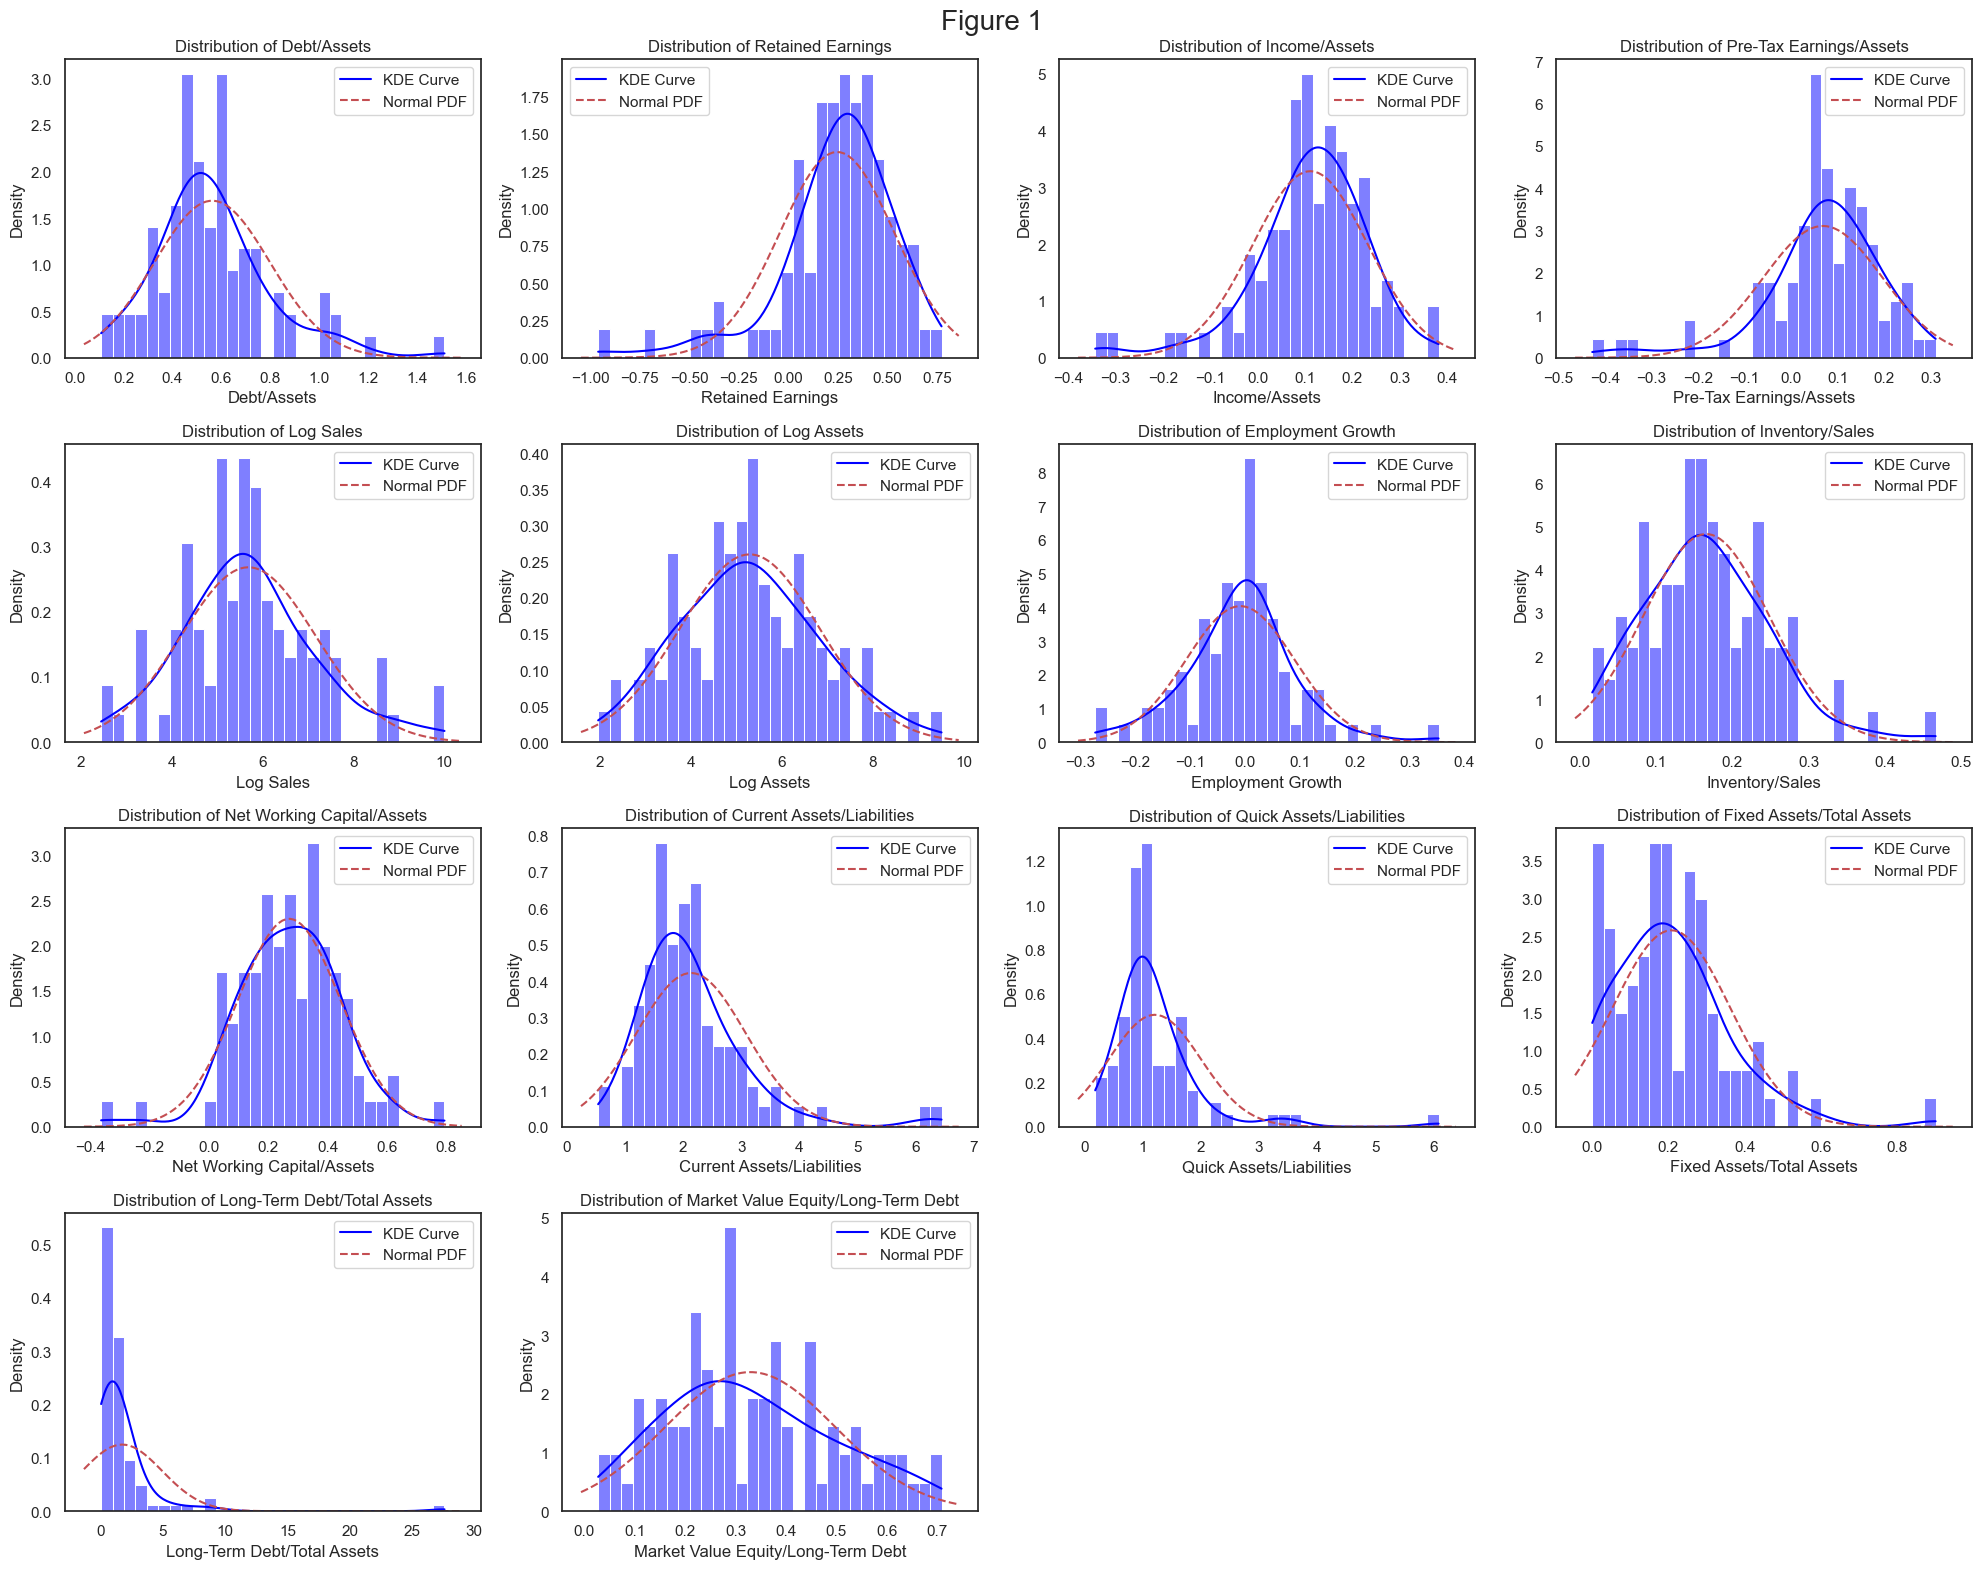

In [292]:
# Data Plotting (variable distribution with respect to the theoretical normal)
# General Layout (column and rows enumeration, figure's size, sub_plot)
num_vars = len(X_train.columns)
cols = 4
rows = (num_vars + cols - 1) // cols
fig, sub_plot = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
sub_plot = sub_plot.flatten()

# Iteration per each variable in X_train (var_i=location of the variable based on index, col_name = variable name)
for var_i, col_name in enumerate(X_train.columns):
# Kernel density distribution of i
# We discard the NaN observations we mentioned earlier
    data = X_train[col_name].dropna()
# sub_plot specs: kde curve, stat for Y sub_plot, color and number of bins (& title)
    sns.histplot(data, kde=True, ax=sub_plot[var_i], stat="density", color="blue", bins=30)
    sub_plot[var_i].set_title(f"Distribution of {col_name}")
# Normal distribution curve for comparison
    mu, std = data.mean(), data.std()
    xmin, xmax = sub_plot[var_i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    sub_plot[var_i].plot(x, p, "r--", label="Normal PDF")
# Maual labelling of KDE curve 
    lines = sub_plot[var_i].get_lines()
    if len(lines) > 0:
        lines[0].set_label("KDE Curve")
    sub_plot[var_i].legend()
# Deletion of unused subplots (we have less variables than available slots for subplots on the page)
for j in range(var_i + 1, len(sub_plot)):
    fig.delaxes(sub_plot[j])

plt.suptitle("Figure 1", fontsize = 20)
plt.tight_layout()
plt.show()

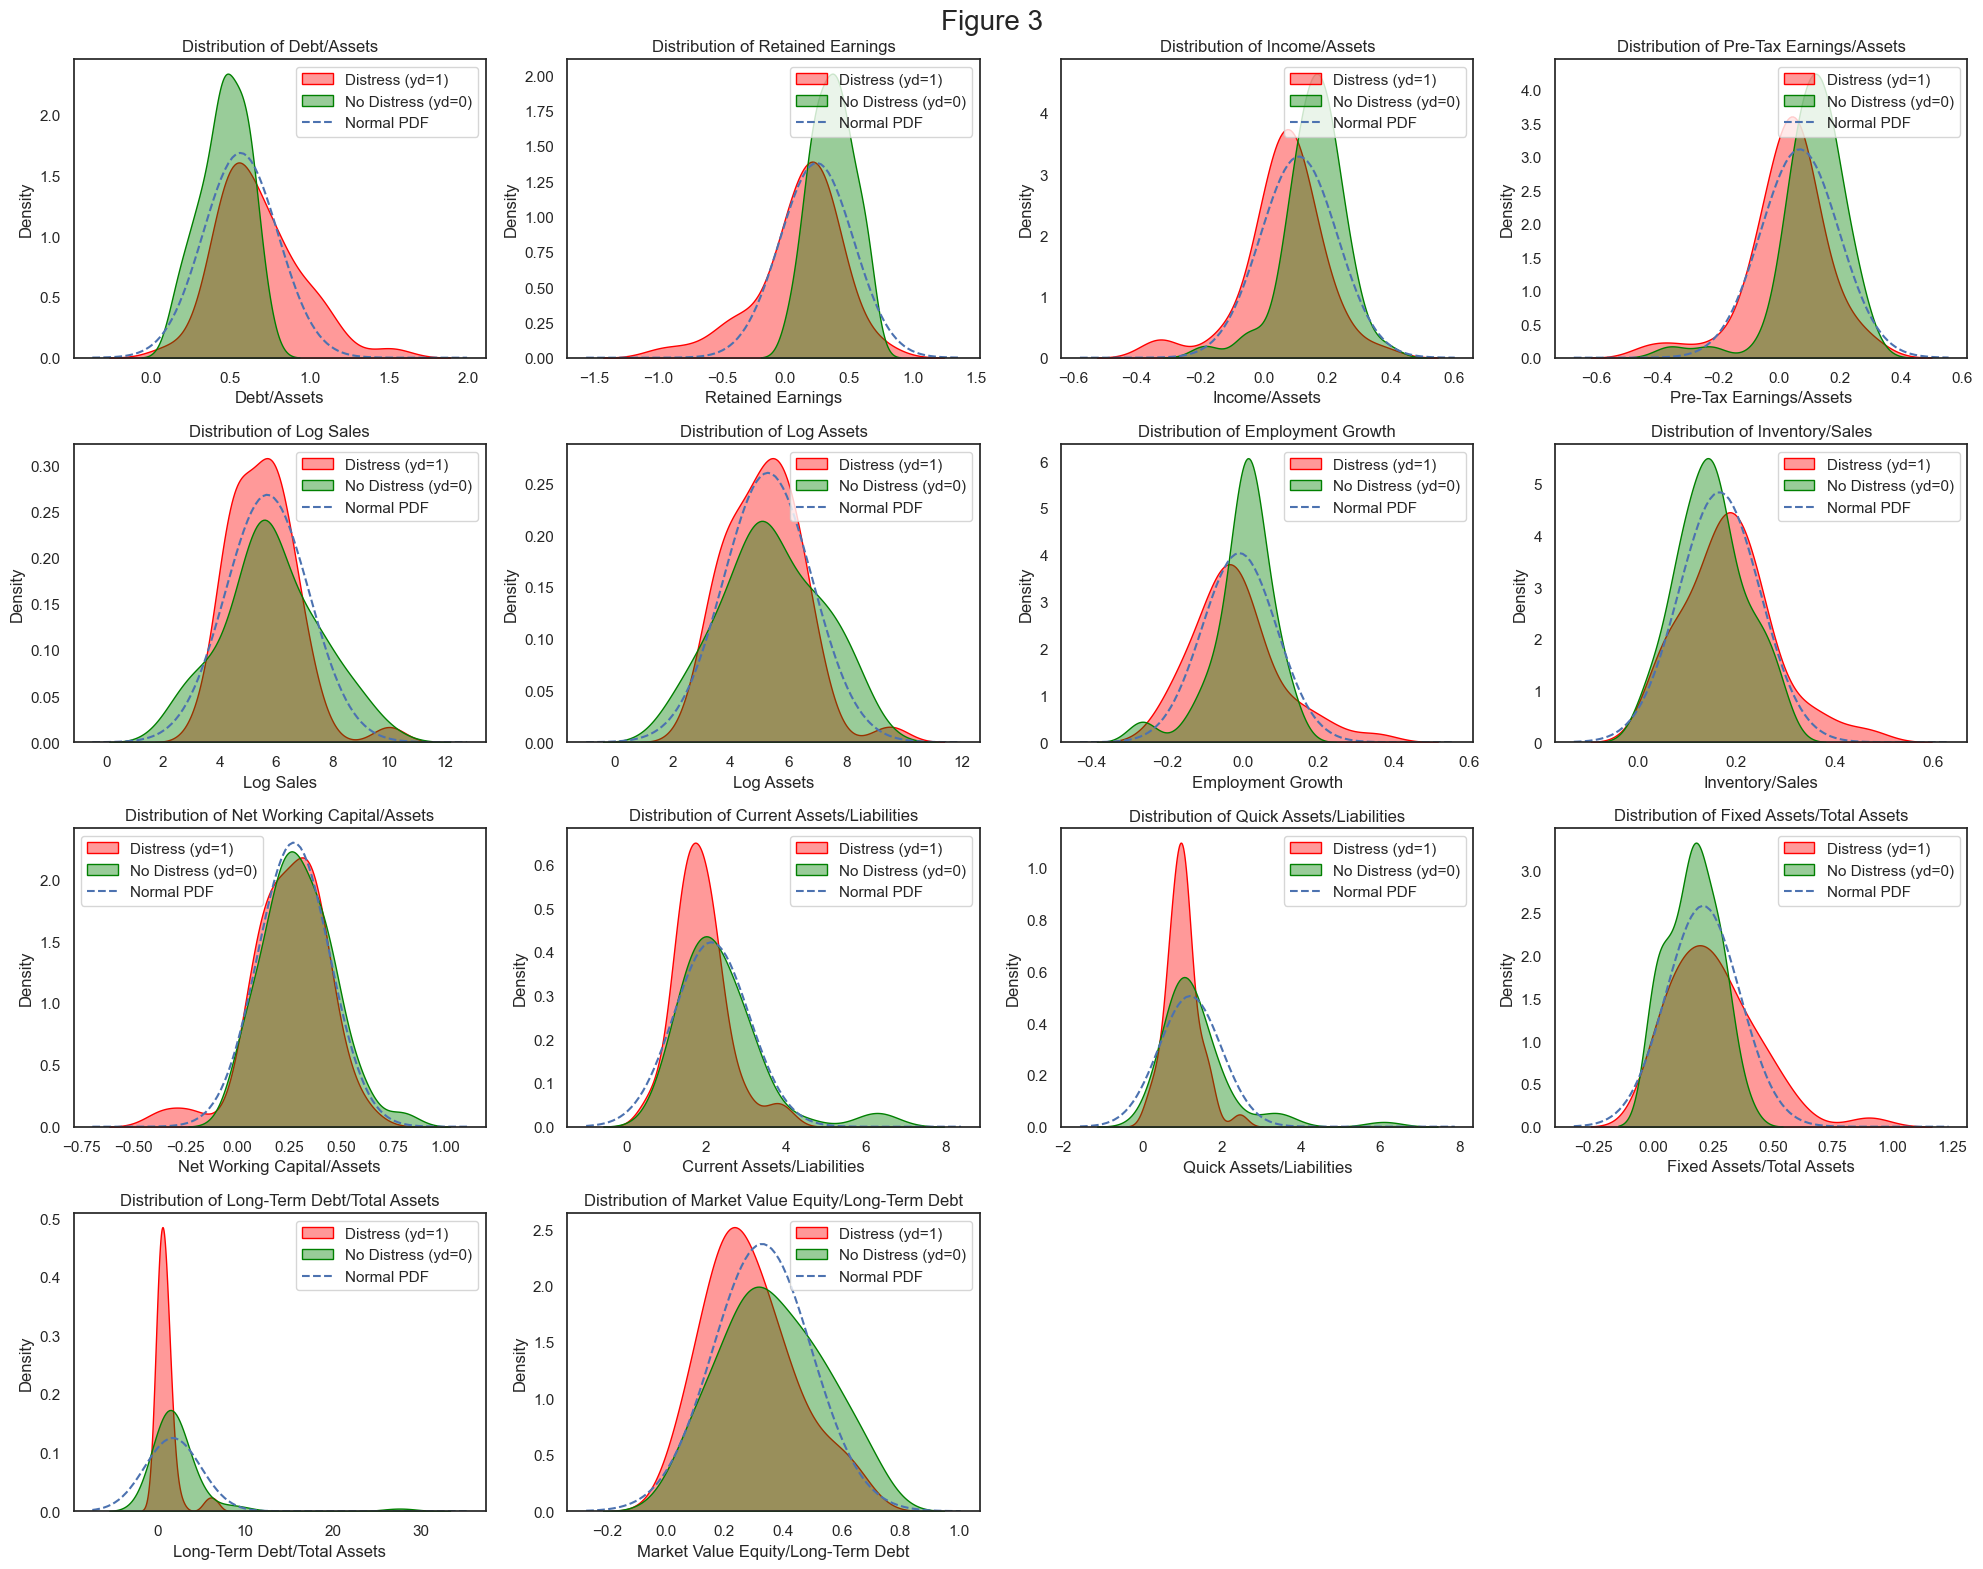

In [298]:
# Data Plotting (variable distribution with respect to the theoretical normal) comparing firms in financial distress (yd=1) with firms out of default risk (yd=0)
# We are back at using the full train dataset, but divided in sub-groups based on financial distress performance 
df_train_distress = df_train[df_train["Financial Distress"] == 1]
df_train_nondistress = df_train[df_train["Financial Distress"] == 0]

# General Layout (column and rows enumeration, figure's size, sub_plot)
num_vars = len(df_train.columns)
cols = 4
rows = (num_vars + cols - 1) // cols
fig, sub_plot = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
sub_plot = sub_plot.flatten()

# Iteration per each variable in X_train (var_i=location of the variable based on index, col_name = variable name)
for var_i, col_name in enumerate(X_train.columns):
    data_distress = df_train_distress[col_name].dropna()
    data_nondistress = df_train_nondistress[col_name].dropna()
# KDE for financial distress
    sns.kdeplot(data_distress, ax=sub_plot[var_i], fill=True, alpha=0.4, color="red", label="Distress (yd=1)")
# KDE for non-distress
    sns.kdeplot(data_nondistress, ax=sub_plot[var_i], fill=True, alpha=0.4, color="green", label="No Distress (yd=0)")

# Normal distribution curve for comparison
    data = X_train[col_name].dropna()
    mu, std = data.mean(), data.std()
    xmin, xmax = sub_plot[var_i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    sub_plot[var_i].plot(x, p, "b--", label="Normal PDF")
    sub_plot[var_i].set_title(f"Distribution of {col_name}")
    sub_plot[var_i].legend()

# Deletion of unused subplots (we have less variables than available slots for subplots on the page)
for j in range(var_i + 1, len(sub_plot)):
    fig.delaxes(sub_plot[j])

plt.suptitle("Figure 3", fontsize = 20)
plt.tight_layout()
plt.show()

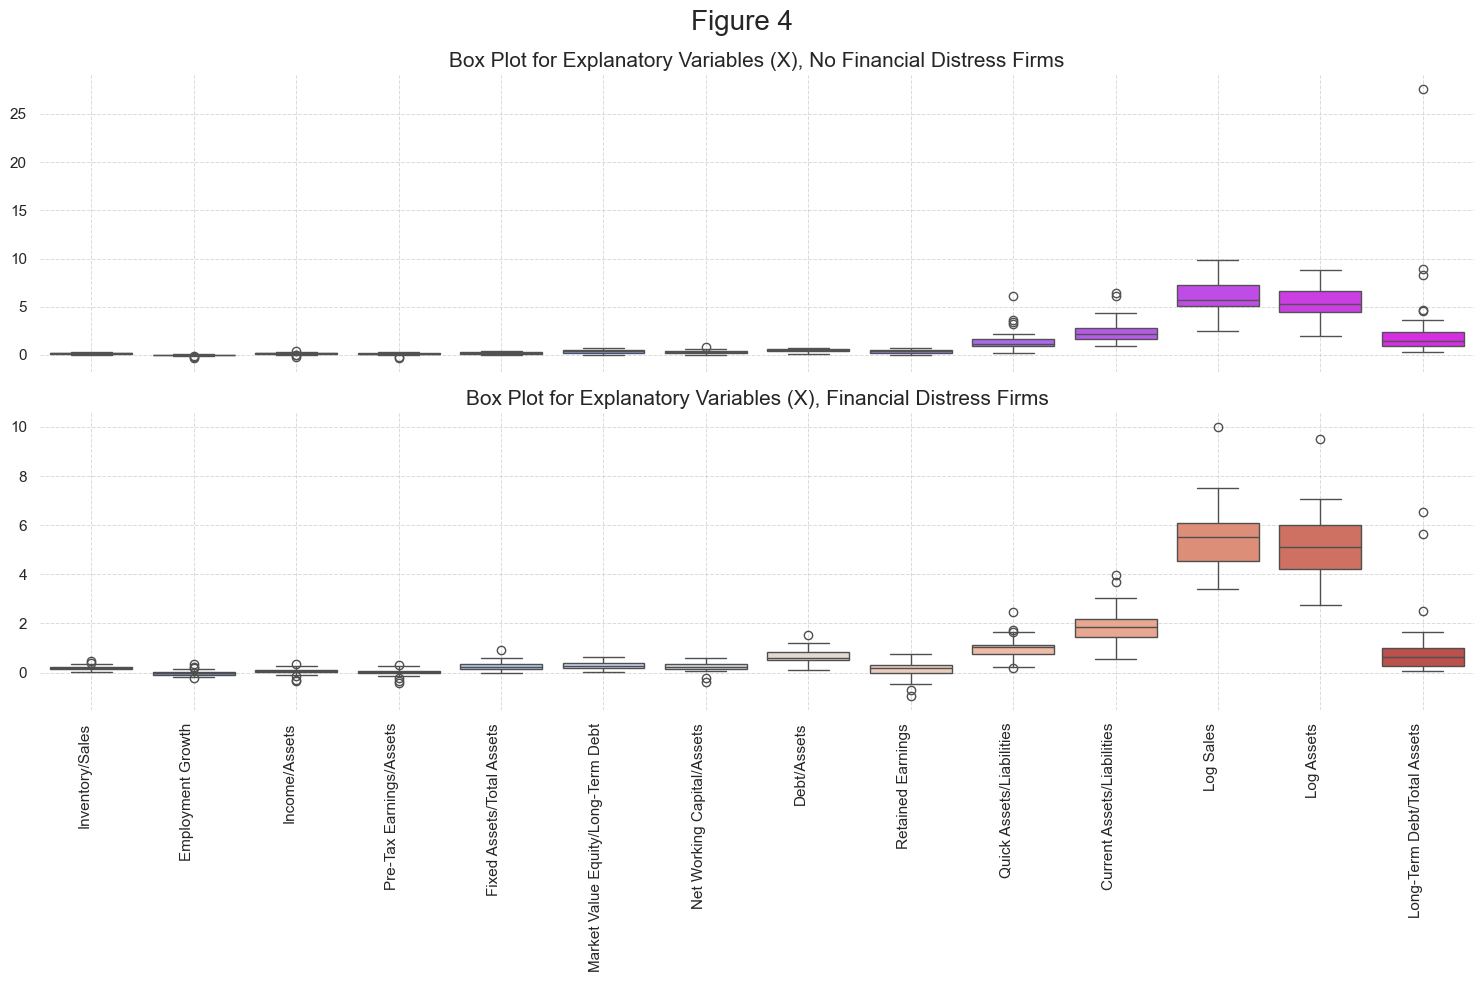

In [301]:
# Data Plotting (box-plot)

# General Layout (column and rows enumeration, figure's size, sub_plot)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Sorting variables by std (so that logs variable move to the right-hand side, for better readibility)
std_values = df_train.std()
sorted_X_var = list(std_values.sort_values(ascending=True).index)

# List of explanatory variables to plot from the general train dataset df_train
# We include all independent variables, but we need to rule out yd first
X = [col for col in sorted_X_var if col != "Financial Distress"]

# Boxplot for non-Financial Distress firms
sns.boxplot(data=df_train_nondistress[X], ax=axes[0], palette="cool")
axes[0].set_title("Box Plot for Explanatory Variables (X), No Financial Distress Firms", fontsize = 15)
axes[0].set_xticklabels(X, rotation=90, ha="right")

# Deactivate the visibility of ticks in the upper sub-plot, so that we can gain more space for the graph 
labels = axes[0].set_xticklabels(X, rotation=90, ha="right")
for label in labels:
    label.set_visible(False)

# Boxplot for Financial Distress firms
sns.boxplot(data=df_train_distress[X], ax=axes[1], palette="coolwarm")
axes[1].set_title("Box Plot for Explanatory Variables (X), Financial Distress Firms", fontsize = 15)
axes[1].set_xticklabels(X, rotation=90, ha="right", )

# Add grid and remove the frame (spines) for each plot
for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(True, linestyle="--", linewidth=0.7, alpha=0.7)

plt.suptitle("Figure 4", fontsize = 20)
plt.tight_layout()
plt.show()

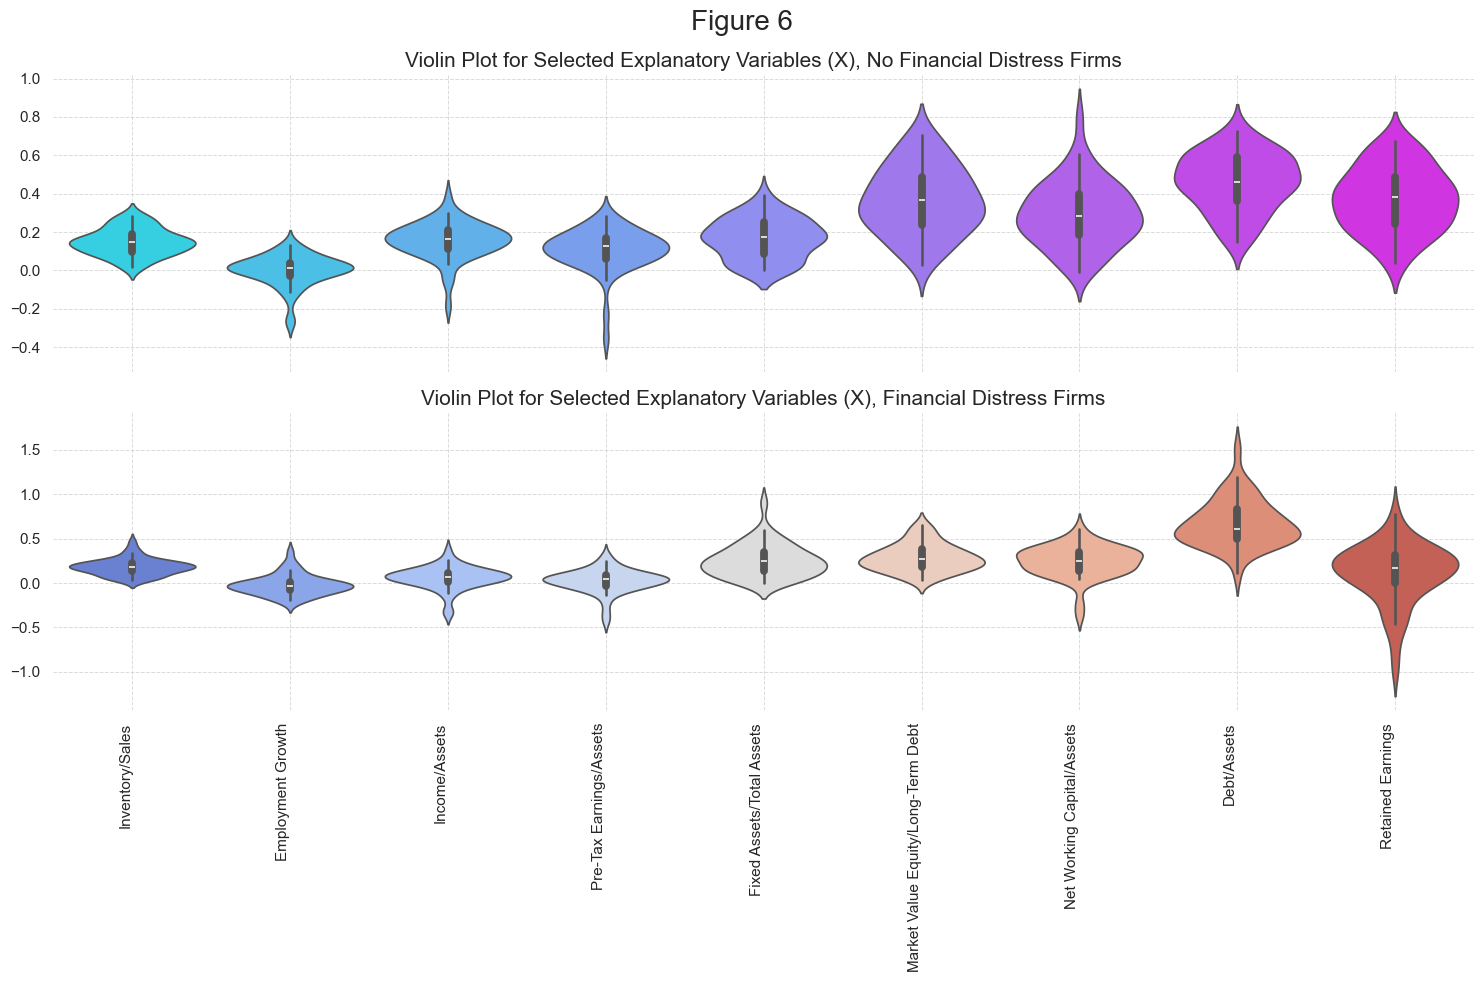

In [303]:
# Data Plotting (Violin-plot) exluding high-range variables (Log Sales, Log Assets, Long-Term Debt/Total Assets)
# General Layout (column and rows enumeration, figure's size, sub_plot)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Sorting variables by std (so that logs variable move to the right-hand side, for better readibility)
std_values = df_train.std()
sorted_X_var = list(std_values.sort_values(ascending=True).index)

# List of explanatory variables to plot from the general train dataset df_train
# We include all independent variables, but we need to rule out yd first
X = [col for col in sorted_X_var if col not in ["Financial Distress", "Log Sales", "Log Assets", "Long-Term Debt/Total Assets", "Current Assets/Liabilities", "Quick Assets/Liabilities"]]

# Violin-plot for No Financial Distress firms
sns.violinplot(data=df_train_nondistress[X], ax=axes[0], palette="cool")
axes[0].set_title("Violin Plot for Selected Explanatory Variables (X), No Financial Distress Firms", fontsize = 15)
axes[0].set_xticklabels(X, rotation=90, ha="right")
# Deactivate the visibility of ticks in the upper sub-plot, so that we can gain more space for the graph 
labels = axes[0].set_xticklabels(X, rotation=90, ha="right")
for label in labels:
    label.set_visible(False)

# Violin-plot for Financial Distress firms
sns.violinplot(data=df_train_distress[X], ax=axes[1], palette="coolwarm")
axes[1].set_title("Violin Plot for Selected Explanatory Variables (X), Financial Distress Firms", fontsize = 15)
axes[1].set_xticklabels(X, rotation=90, ha="right", )

# Background grid and frame (spines) removal for each plot
for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(True, linestyle="--", linewidth=0.7, alpha=0.7)

plt.suptitle("Figure 6", fontsize = 20)
plt.tight_layout()
plt.show()

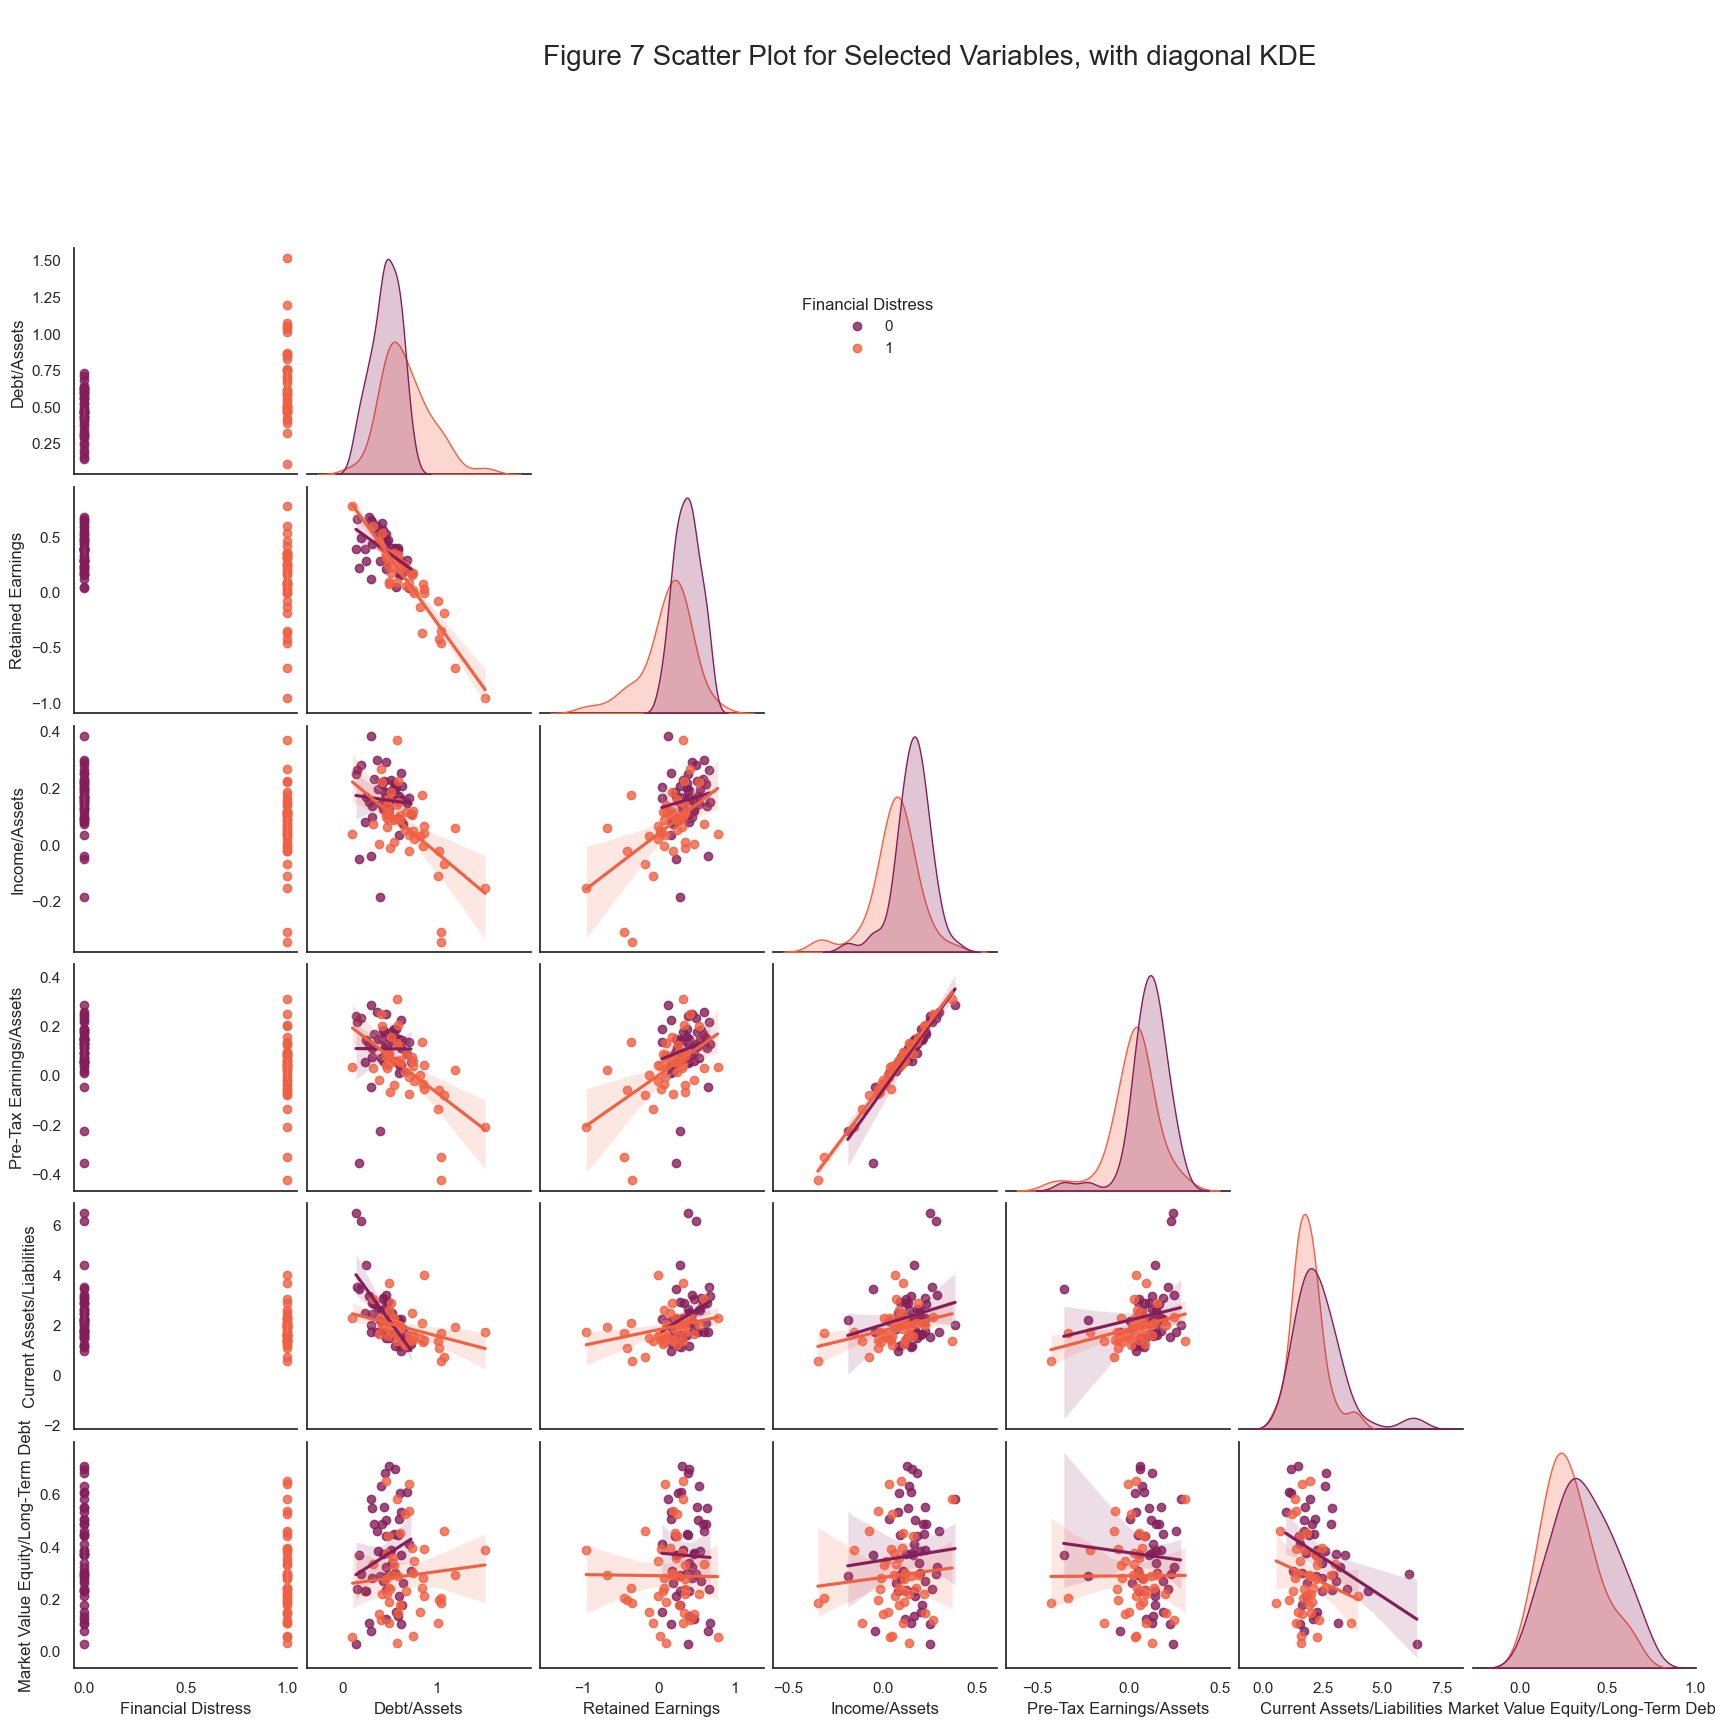

In [304]:
# Data Plotting (Scatter-plot & diagonal KDE), selected variables relative distribution per subgroup (No Financial Distress & Financial Distress firms)
# Filtering of target variables (explanatory + dependent)
Xy = [col for col in df_train.columns if col not in 
        ["Inventory/Sales", 
         "Net Working Capital/Assets", 
         "Long-Term Debt/Total Assets", 
         "Log Sales", 
         "Log Assets", 
         "Fixed Assets/Total Assets", 
         "Quick Assets/Liabilities", 
         "Employment Growth"]]

# Scatter-plot + Diagonal KDE (g)
# No need to deploy separate datasets for the 2 sub-groups of firms, as sns.pairplot has already an integrated function (hue) to split the sample
# "reg" in kind offers much more insights than only "scatter", by adding the respective trend curves and std range
g = sns.pairplot(df_train, 
                 hue="Financial Distress", 
                 hue_order=[0, 1], 
                 vars=Xy, 
                 kind="reg", 
                 diag_kind="kde", 
                 palette="rocket", 
                 corner=True)

# Deletion of unused subplots (we have less variables than available slots for subplots on the page)
g.fig.axes[0].set_visible(False) 

# Figure elements positioning adjustments
g._legend.set(bbox_to_anchor=(0.5, 0.8), transform=g.fig.transFigure)
g._legend._ncol = 2
g.fig.subplots_adjust(top=0.99)

g.fig.suptitle("Figure 7 Scatter Plot for Selected Variables, with diagonal KDE", 
               fontsize=20, y=0.97, ha="center", linespacing=1.5)
plt.show()

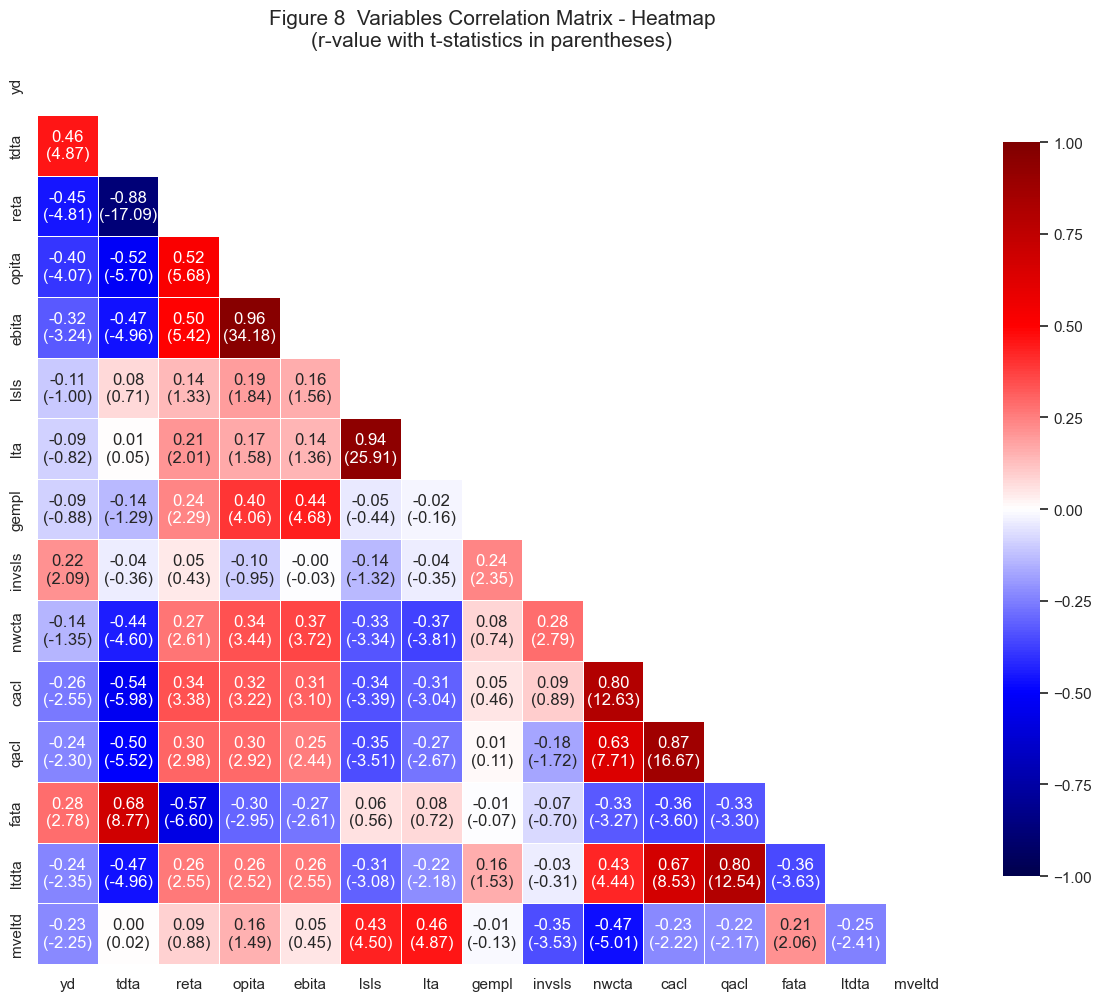

In [305]:
# Data Plotting (Correlation Heatmap)
# Variable renaming (inverted variables dictionary from full names to acronyms)
df_train_short = df_train.copy()
df_train_short.rename(columns=inverted_variables, inplace=True)

# Correlation matrix
corr_matrix = df_train_short.corr()
# Sample size
n = df_train.shape[0]

# t-statistics derived from correlation values
with np.errstate(divide="ignore", invalid="ignore"):
    t_stat_matrix = corr_matrix * np.sqrt((n - 2) / (1 - corr_matrix**2))
    t_stat_matrix = t_stat_matrix.round(2)

# For each cell, we want to have both the correlation index, as well as the just computed t-statistics
annot_matrix = corr_matrix.copy().astype(str)

for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
# We only want to keep the lower triangle and diagonal of the full correlation matrix
        if i >= j: 
            r = corr_matrix.iloc[i, j]
            t = t_stat_matrix.iloc[i, j]
            annot_matrix.iloc[i, j] = f"{r:.2f}\n({t:.2f})"
        else:
            annot_matrix.iloc[i, j] = ""

# We manually hide the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Heat-map plot
# General Layout (figure's size and style)
plt.figure(figsize=(12, 10))
sns.set(style="white")

sns.heatmap(corr_matrix,
            mask=mask,
            annot=annot_matrix,
            fmt="",               
            cmap="seismic",          
            vmin=-1, vmax=1,       
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .8})


plt.title("Figure 8  Variables Correlation Matrix - Heatmap\n(r-value with t-statistics in parentheses)", 
          fontsize=15)
plt.tight_layout()
plt.show()

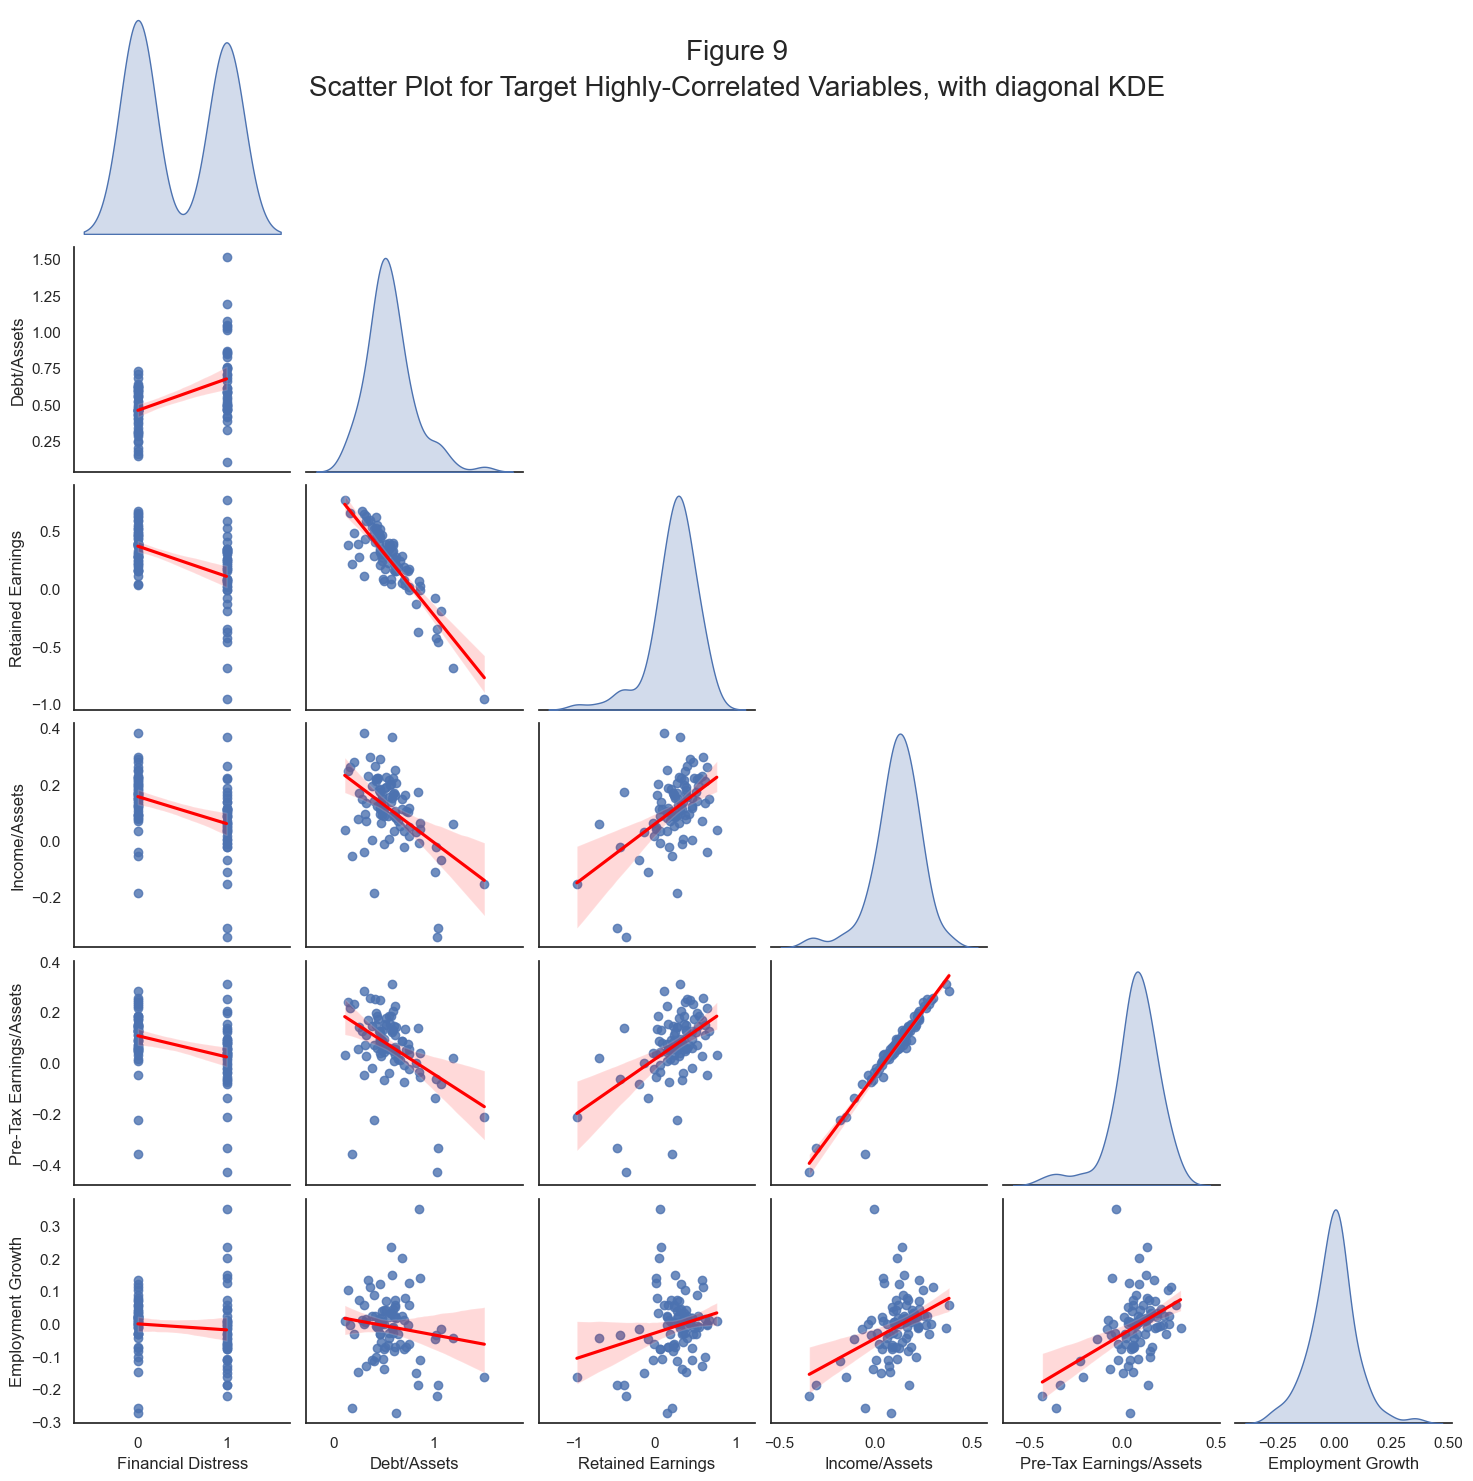

In [313]:
# Data Plotting (Scatter-plot & diagonal KDE), highly correlated variables relative distribution per subgroup (No Financial Distress & Financial Distress firms)
# Filtering of target variables (explanatory + dependent): Financial Distress, Debt/Assets, Retained Earnings, Income/Assets, Pre-Tax Earnings/Assets, Employment Growth.
Xy = [col for col in df_train.columns if col in 
        ["Financial Distress", 
         "Debt/Assets", 
         "Retained Earnings",
         "Income/Assets", 
         "Pre-Tax Earnings/Assets",
         "Employment Growth"]]

# Scatter-plot + Diagonal KDE (g)
# "reg" in kind offers much more insights than only "scatter", by adding the respective trend curves and std range
# bivariate clouds of points
g = sns.pairplot(df_train,  
                 vars=Xy, 
                 kind="reg", 
                 diag_kind="kde",
                 plot_kws={"line_kws": {"color": "red"}},
                 corner=True)

# Deletion of unused subplots (we have less variables than available slots for subplots on the page)
g.fig.axes[0].set_visible(False) 

# Figure elements positioning adjustments
g.fig.subplots_adjust(top=0.99)
g.fig.suptitle("Figure 9\nScatter Plot for Target Highly-Correlated Variables, with diagonal KDE", 
               fontsize=20, y=0.97, ha="center", linespacing=1.5)
plt.show()